### Importing Data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 17:04:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/29 17:04:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/04/29 17:04:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
text_rdd = spark.sparkContext.textFile('adult100m')
text_rdd_cleaned = text_rdd.map(lambda x: tuple(x.split(',')))

In [3]:
schema = StructType([
    StructField("Age", StringType(), True),  
    StructField("WorkClass", StringType(), True),
    StructField("Fnlwgt", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("EducationNum", StringType(), True),
    StructField("MaritalStatus", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Relationship", StringType(), True),
    StructField("Race", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("CapitalGain", StringType(), True),
    StructField("CapitalLoss", StringType(), True),
    StructField("HoursPerWeek", StringType(), True),
    StructField("NativeCountry", StringType(), True),
    StructField("Income", StringType(), True)
])

spark_dataframe = spark.createDataFrame(text_rdd_cleaned, schema)

In [4]:
spark_dataframe.show(5)

24/04/29 17:05:12 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker


+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|Age|       WorkClass|Fnlwgt|Education|EducationNum|     MaritalStatus|       Occupation| Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
| 39|       State-gov| 77516|Bachelors|          13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|       2174|          0|          40|United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|          13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|          0|          0|          13|United-States| <=50K|
| 38|         Private|215646|  HS-grad|           9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|         

### Data Exploration 

In [5]:
# How many records in this dataframe? 
spark_dataframe.count()

100000000

In [6]:
# Data Type Handling 
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for col_name in NumericalDataType:
    spark_dataframe = spark_dataframe.withColumn(col_name, col(col_name).cast('float'))

In [7]:
# Missing Data / Imputations 
null_counts = spark_dataframe.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_dataframe.columns))
null_counts.show()

+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|Age|WorkClass|Fnlwgt|Education|EducationNum|MaritalStatus|Occupation|Relationship|Race|Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|  0|        0|     0|        0|           0|            0|         0|           0|   0|  0|          0|          0|           0|            0|     0|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+



#### Column Descriptions 
- Age : Age of person in years (Integer)
- WorkClass : Type of work that the person does (Catergorical)
- Fnlwgt : ? (Integer)
- Education : Highest Level of Education (Catergorical)
- EducationNum : Number of years completed of education (Integer) 
- MaritalStatus : Marital status of the person (Catergorical)
- Occupation : Person's profession (Catergorical) 
- Relationship : Familial status of the person (Catergorical)
- Race : Race of person (Catergorical)
- Sex : Sex of person (Catergorical)
- CapitalGain : ? (Integer)
- CapitalLoss : ? (Integer)
- HoursPerWeek : Hours per week that the person words (Integer) 
- NativeCountry : Country where the person lives (Catergorical) 
- Income : Whether or not the person makes over or under $50k (Catergorical) 

### Data Visualization

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
sampled_df = spark_dataframe.sample(withReplacement = False, fraction = 0.001, seed = 505)
sampled_df.count()

100365

#### Numerical Variables

Age


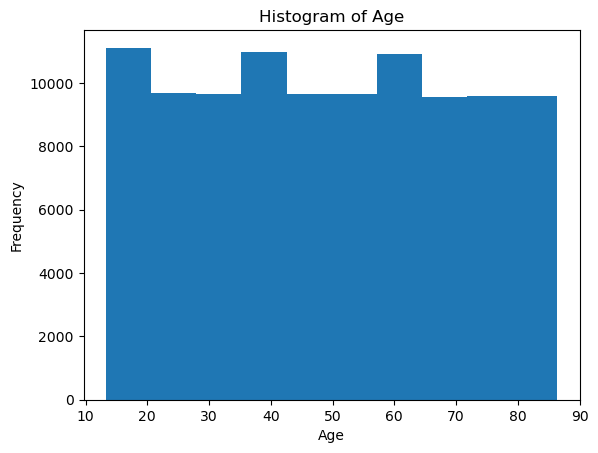

Fnlwgt


In [ ]:
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for i in NumericalDataType:

    print(i)
    hist_data = sampled_df.select(i).rdd.flatMap(lambda x: x).histogram(10)
    bins = hist_data[0]
    frequencies = hist_data[1]
    plt.bar(bins[:-1], frequencies, width=bins[1]-bins[0])
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(i))
    plt.show()

In [ ]:
heatmap_data = sampled_df.select(NumericalDataType).toPandas()

In [ ]:
sns.heatmap(heatmap_data)

#### Catergorical Variables

In [ ]:
list_of_columns = list(spark_dataframe.columns)
print(list_of_columns)

NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek', 'Education']

CatergoricalDataType = list_of_columns.remove(NumericalDataType)

In [ ]:
for i in CatergoricalDataType:
    
    print(i)
    value_counts = sampled_df.groupBy(i).count().orderBy(i).collect()
    
    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]
    
    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('Bar plot of {}'.format(i))
    plt.show()

#### Response Variables

### Data Preprocessing

- Data types have been changed above for ease of visualization.
- There doesn't seem to be extreme outliers.

In [ ]:
# Changing Some Variables into Boolean Variables.


### Data Download and Requirements

- Data can be downloaded off : https://www.kaggle.com/datasets/brijeshbmehta/adult-datasets